In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

dfs_edi = pd.read_html("INDEX.html")[5]
df_pop = pd.read_html("POP.html")[0]

# Seznam zemí EU (27 členů)
eu_countries = [
    "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czech Republic",
    "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary",
    "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta",
    "Netherlands", "Poland", "Portugal", "Romania", "Slovakia", "Slovenia",
    "Spain", "Sweden"
]

# Vyfiltrování pouze EU zemí z obou datasetů
# Democracy Index
df_edi_eu = dfs_edi[dfs_edi['Country'].isin(eu_countries)].copy()

# Populace
df_pop_eu = df_pop[df_pop["Location"].isin(eu_countries)].copy()

# Spojení tabulek
df_final = pd.merge(df_edi_eu, df_pop_eu[['Location', 'Population']], left_on='Country', right_on="Location", how='inner')

latest_year = "2024"
old_year_decline = '2010'
base_year_class = '2006'

# VÝPOČTY

# 1. Pořadí podle indexu demokracie (aktuální rok)
df_final['Rank_Index'] = df_final[latest_year].rank(ascending=False)

# 2. Pořadí podle poklesu indexu (2010 - 2025/2024)
# Pokles = Hodnota 2010 - Hodnota 2024 (Kladné číslo = Pokles/Zhoršení)
df_final['Decline_Value'] = df_final[old_year_decline] - df_final[latest_year]
# Rank: Největší pokles (nejvyšší kladné číslo).
df_final['Rank_Decline'] = df_final['Decline_Value'].rank(ascending=False)

# 3. Celkový index pro EU (vážený počtem obyvatel)
weighted_index = np.average(df_final[latest_year], weights=df_final['Population'])

print("\n" + "="*40)
print(f"Celkový vážený Index demokracie pro EU ({latest_year}): {weighted_index:.4f}")
print("="*40 + "\n")

# Zobrazení tabulky výsledků
results = df_final[['Country', latest_year, 'Rank_Index', 'Decline_Value', 'Rank_Decline']].sort_values('Rank_Index')
print(results.head(27).to_string(index=False))


Celkový vážený Index demokracie pro EU (2024): 7.9989

       Country  2024  Rank_Index  Decline_Value  Rank_Decline
        Sweden  9.39         1.0           0.11          11.5
       Finland  9.30         2.0          -0.11          18.0
       Denmark  9.28         3.0           0.24           8.0
       Ireland  9.19         4.0          -0.40          25.0
   Netherlands  9.00         5.0          -0.01          15.0
    Luxembourg  8.88         6.0           0.00          14.0
       Germany  8.73         7.0          -0.35          22.5
       Austria  8.28         8.0           0.21           9.0
         Spain  8.13         9.5           0.03          13.0
       Estonia  8.13         9.5          -0.45          26.0
Czech Republic  8.08        11.5           0.11          11.5
      Portugal  8.08        11.5          -0.06          16.0
        Greece  8.07        13.0          -0.15          20.0
        France  7.99        14.0          -0.22          21.0
         Malta

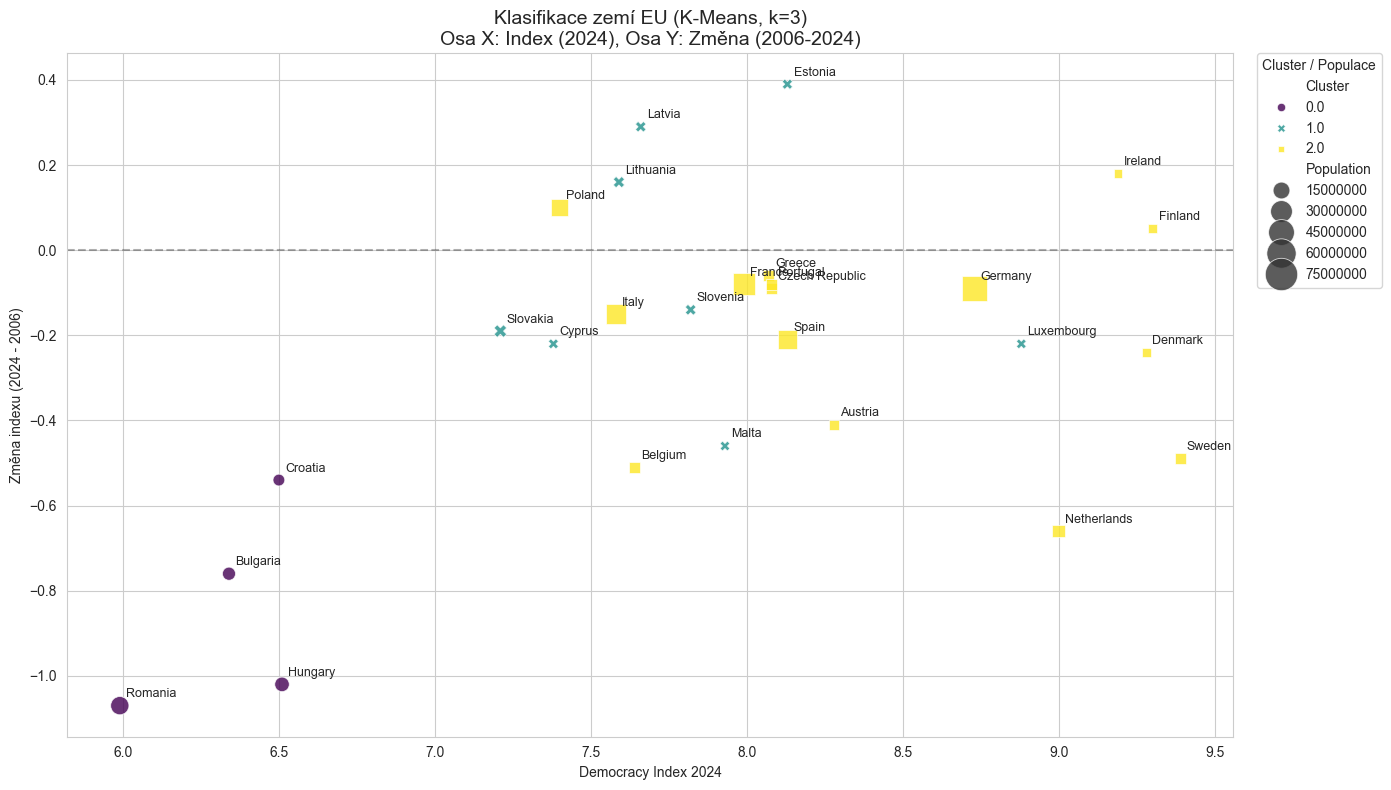

In [4]:
#KLASIFIKACE (CLUSTERING) A VIZUALIZACE

# Příprava dat pro K-Means
# Features: Index(2024), Rozdíl(2024-2006), Log(Population)
df_final['Diff_Latest_2006'] = df_final[latest_year] - df_final[base_year_class]
df_final['Log_Pop'] = np.log10(df_final['Population'])

features = [latest_year, 'Diff_Latest_2006', 'Log_Pop']
X = df_final[features].dropna() # Odstranění chybějících hodnot

# Škálování dat (nutné pro K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means (zkoušíme např. 3 clustery)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_final.loc[X.index, 'Cluster'] = kmeans.fit_predict(X_scaled)

# Vizualizace
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Scatter plot
scatter = sns.scatterplot(
    data=df_final,
    x=latest_year,
    y='Diff_Latest_2006',
    hue='Cluster',
    style='Cluster',
    size='Population',
    sizes=(50, 600),
    palette='viridis',
    alpha=0.8
)

# Popisky zemí
for i in df_final.index:
    plt.text(
        df_final.loc[i, latest_year]+0.02,
        df_final.loc[i, 'Diff_Latest_2006']+0.02,
        df_final.loc[i, 'Country'],
        fontsize=9
    )

plt.title(f'Klasifikace zemí EU (K-Means, k={k})\nOsa X: Index ({latest_year}), Osa Y: Změna ({base_year_class}-{latest_year})', fontsize=14)
plt.xlabel(f'Democracy Index {latest_year}')
plt.ylabel(f'Změna indexu ({latest_year} - {base_year_class})')
plt.axhline(0, color='black', linestyle='--', alpha=0.3) # Nulová změna
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title="Cluster / Populace")
plt.tight_layout()

plt.show()